# 1D Adjoint Optimization

In [46]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from matplotlib import pyplot as plt


seed = 240
np.random.seed(seed) # 동일한 난수 sequence를 생성하기 위해 seed를 고정한다.
Air = mp.Medium(index=1)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

In [47]:
resolution = 20

Sx = 6
Sy = 8
cell_size = mp.Vector3(Sx, Sy)
pml_layers = [mp.PML(0.5)]

In [48]:
'''
한 쪽에서만 특정한 모드의 eigenmode를 발생시키는 EigenmodeSource를 사용한다.
이때 GaussianSource를 사용하여 특정한 주파수와 주파수 폭을 갖는 EignemodeSource를 생성한다.
'''


fcen = 1 / 1.55
width = 0.1
fwidth = width * fcen
source_center = [0, 3, 0]
source_size = mp.Vector3(6, 0, 0)
kpoint = mp.Vector3(0, -1, 0)
source = [
    mp.EigenModeSource(
        mp.GaussianSource(frequency=fcen, fwidth=fwidth),
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]

In [49]:
'''
Design region을 정의한다.


현재 디자인하려는 영역과 빛의 전파 방향을 고려하여, Design variable을 y축 방향으로 Ny개로 잡았다. material1과 material2 두 물질로 구성된 Design region에서 물질 속성은 
U_MEAN 방식에 의해 가중 평균으로 정해진다. 이때 weights가 0에 가까울수록 material1이 더 많고, 1에 더 가까울수록록 material2가 더 많다.
특별히 weights가 명시되어 있지 않으면 weights는 두 물질이 1:1로 균등하게 분포되도록 설정된다. 

비율을 달리 하고싶으면 다음과 같이 설정한다.

weights = np.full((Nx, Ny), 0.3)
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si, weights=weights, grid_type="U_MEAN")
'''

Ny = 20

design_variables = mp.MaterialGrid(mp.Vector3(0, Ny), SiO2, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables, volume=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(2, 3, 0))
)

geometry = [
    mp.Block(center=mp.Vector3(), material=Si, size=mp.Vector3(2, 8, 0)),
    mp.Block(center=design_region.center, 
                     size=design_region.size, 
                     material=design_variables),  # design region
    # mp.Block(center=design_region.center, size=design_region.size, material=design_variables,
    #        e1=mp.Vector3(x=-1).rotate(mp.Vector3(z=1), np.pi/2), e2=mp.Vector3(y=1).rotate(mp.Vector3(z=1), np.pi/2))
    #
    # The commented lines above impose symmetry by overlapping design region with the same design variable. However,
    # currently there is an issue of doing that; We give an alternative approach to impose symmetry in later tutorials.
    # See https://github.com/NanoComp/meep/issues/1984 and https://github.com/NanoComp/meep/issues/2093
]

In [50]:
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    eps_averaging=False,
    resolution=resolution,
)

In [51]:
'''
우리는 목표 지점에서의 Power를 최대화해야하기 때문에, 이를 위해 Objective function을 정의한다. 우리는 Fundamental mode에서의 Power를
최대화해야 하기 때문에, 이를 반영하여 해당 모드의 정보를 추출하도록 먼저 EigenmodeCoefficient를 통해 "objective quantity"를 정의한다.
'''


TE0 = mpa.EigenmodeCoefficient(
    sim, mp.Volume(center=mp.Vector3(0, -3, 0), size=mp.Vector3(x=2)), mode=1
)
ob_list = [TE0]

In [52]:
'''
우리의 objective function은 해당 objective quantity의 절대값의 제곱으로 정의된다.
'''

def J(alpha):
    return npa.abs(alpha) ** 2

In [53]:
'''
이상의 정보들로 OptimizationProblem을 정의한다.
'''


opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=design_region,
    fcen=fcen,
    df=0,
    nf=1,
    decay_by=1e-5
)

In [54]:
'''
먼저 design parameter의 초기값을 설정한다. 이때 무작위한 값으로 초기화한다.
'''


x0 = np.random.rand(Ny) # 초기 추정치를 설정하기 위해 design parameter를 무작위한 값으로 설정한다.
opt.update_design([x0])

     block, center = (0,0,0)
          size (2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0,0,0)
          size (2,3,0)
          axes (1,0,0), (0,1,0), (0,0,1)


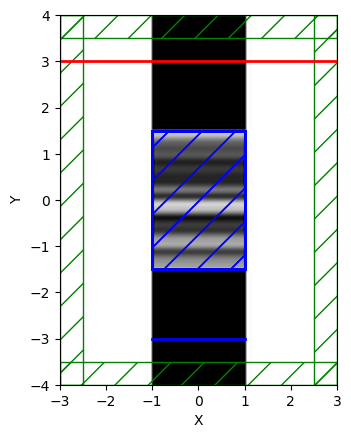

In [55]:
opt.plot2D(True, frequency=1 / 1.55)
plt.show()

In [56]:
'''
Solver object를 직접 호출함으로써 optimization을 수행한다. 이 object는 objective function evaluation f0와 gradient dJ_du를 반환한다.
'''


f0, dJ_du = opt()

Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 8.60691e-05 s
Working in 2D dimensions.
Computational cell is 6 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0,0,0)
          size (2,3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.00776196 s
-----------
MPB solved for frequency_1(0,-1,0) = 0.30066 after 61 iters
MPB solved for frequency_1(0,-2.19008,0) = 0.647662 after 15 iters
MPB solved for frequency_1(0,-2.18154,0) = 0.645161 after 10 iters
MPB solved for frequency_1(0,-2.18154,0) = 0.645161 after 1 iters
run 0 finished at t = 176.4 (7056 timesteps)
MPB solved for frequency_1(0,0.645161,0) = 0.189753 after 22 iters
MPB solved for frequency_1(0,2.19355,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,2.193548,0.000000)
Starting adjoin

In [57]:
print(dJ_du)

[ 1.56679568  1.3814942   0.97617524  0.07050494  0.27834741  0.79486966
  0.94760124  0.50212574  2.56790096 -0.34618203 -0.44547527 -1.44308267
 -0.67802598 -1.38806212 -0.62248977 -1.07216666 -1.61839644 -0.82544256
 -2.31821311  0.41067734]


In [58]:
print(np.rot90(dJ_du.reshape(1,Ny)))

[[ 0.41067734]
 [-2.31821311]
 [-0.82544256]
 [-1.61839644]
 [-1.07216666]
 [-0.62248977]
 [-1.38806212]
 [-0.67802598]
 [-1.44308267]
 [-0.44547527]
 [-0.34618203]
 [ 2.56790096]
 [ 0.50212574]
 [ 0.94760124]
 [ 0.79486966]
 [ 0.27834741]
 [ 0.07050494]
 [ 0.97617524]
 [ 1.3814942 ]
 [ 1.56679568]]


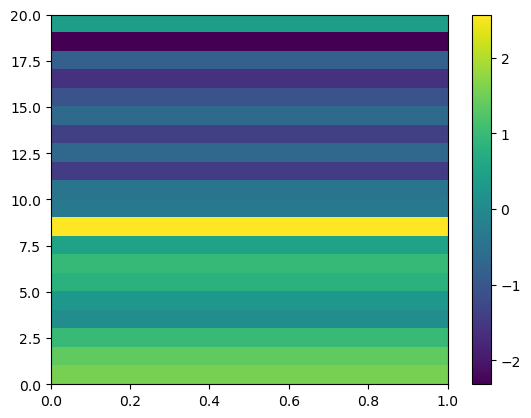

In [59]:
plt.figure()
plt.imshow(np.rot90(dJ_du.reshape(1,Ny)), extent=[0, 1, 0, Ny], aspect='auto')
plt.colorbar()

In [60]:
'''
Inverse Design이 제대로 되었는지를 확인하기 위해 finite difference approximation을 수행한다.
'''


db = 1e-3
choose = 20
# resolution = 30 
# opt.sim.resolution = resolution
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)

-----------
Initializing structure...
time for choose_chunkdivision = 7.89165e-05 s
Working in 2D dimensions.
Computational cell is 6 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0,0,0)
          size (2,3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.00873494 s
-----------
MPB solved for frequency_1(0,-1,0) = 0.30066 after 61 iters
MPB solved for frequency_1(0,-2.19008,0) = 0.647662 after 15 iters
MPB solved for frequency_1(0,-2.18154,0) = 0.645161 after 10 iters
MPB solved for frequency_1(0,-2.18154,0) = 0.645161 after 1 iters
run 2 finished at t = 197.375 (7895 timesteps)
MPB solved for frequency_1(0,0.645161,0) = 0.189753 after 22 iters
MPB solved for frequency_1(0,2.19355,0) = 0.645161 after 1 iters
Dominant planewave for band 1: (0.000000,2.193548,0.000000)
-----------
Initializing structure...

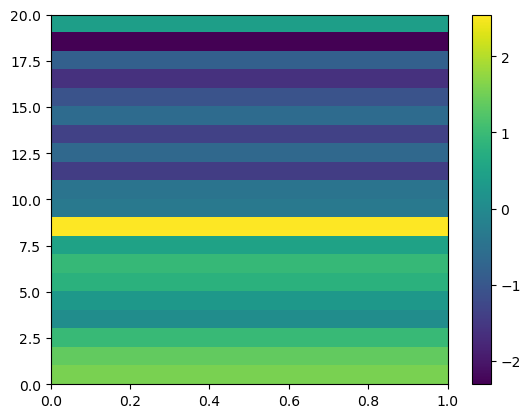

In [78]:
plt.figure()
plt.imshow(np.rot90(np.squeeze(g_discrete).reshape(1,Ny)), extent=[0, 1, 0, Ny], aspect='auto')
plt.colorbar()

In [62]:
'''
Adjoint optimization의 결과와 Finite difference approximation의 결과를 선형회귀를 통해 비교한다.
'''

(m, b) = np.polyfit(dJ_du[idx], np.squeeze(g_discrete),1)

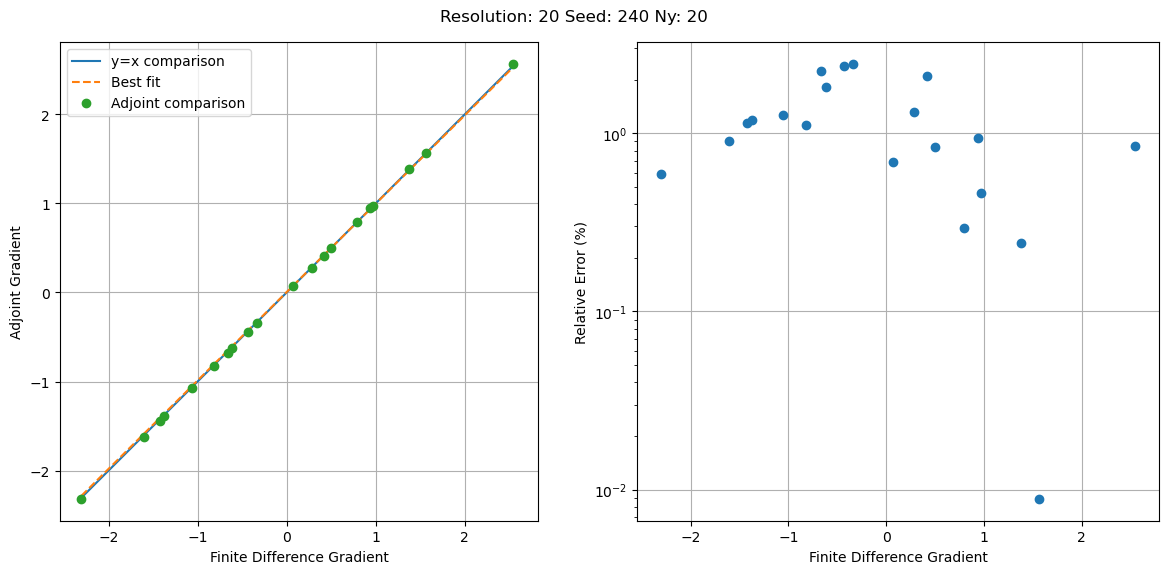

In [64]:

'''
개발 노트

1. Design region이 source의 width보다 작을 경우, gradient값이 불안정해져 relative error가 매우 높게 나타났다. 
Source에서 Design region으로 빛이 입사하는 순간 optimization이 정확하게 되지 않는 것 같아 보인다.

2. 순수 공기 매질에서 design region을 source보다 작게 잡은 경우 1의 경우와 동일하게 나타났지만, SiO2/Si에서는 상대적으로 더 안정적인 결과를 보이는 것 같다.

'''

min_g = np.min(g_discrete)
max_g = np.max(g_discrete)

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g, max_g], [min_g, max_g], label="y=x comparison")
plt.plot([min_g, max_g], [m * min_g + b, m * max_g + b], "--", label="Best fit")
plt.plot(g_discrete, dJ_du[idx], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err = (
    np.abs(np.squeeze(g_discrete) - np.squeeze(dJ_du[idx]))
    / np.abs(np.squeeze(g_discrete))
    * 100
)
plt.semilogy(g_discrete, rel_err, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Seed: {} Ny: {}".format(resolution, seed, Ny))
plt.show()

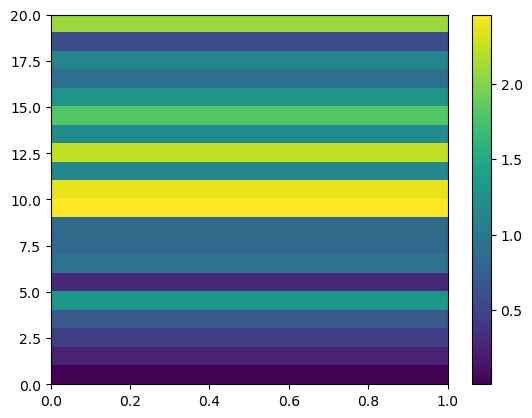

In [69]:
plt.figure()
plt.imshow(np.rot90(rel_err.reshape(1,Ny)), extent=[0, 1, 0, Ny], aspect='auto')
plt.colorbar()

     block, center = (0,0,0)
          size (2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0,0,0)
          size (2,3,0)
          axes (1,0,0), (0,1,0), (0,0,1)


(-3.0, 3.0, -4.0, 4.0)

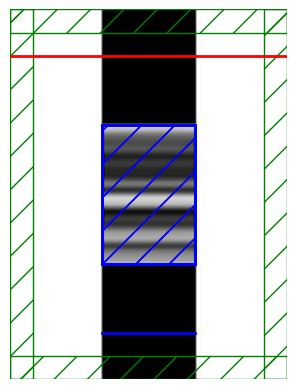

In [70]:
opt.update_design([x0])
opt.plot2D(True,
           plot_monitors_flag = True,
           output_plane = mp.Volume(center=mp.Vector3(0, 0, 0), size=mp.Vector3(6,8)),
)

plt.axis("off")

     block, center = (0,0,0)
          size (2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0,0,0)
          size (2,3,0)
          axes (1,0,0), (0,1,0), (0,0,1)


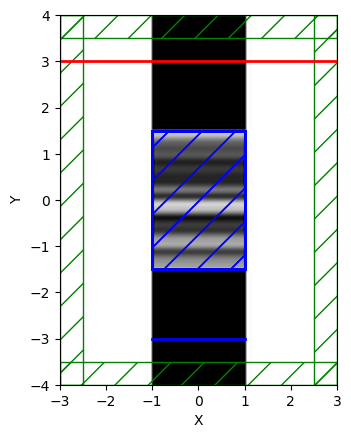

-----------
Initializing structure...
time for choose_chunkdivision = 0.000115871 s
Working in 2D dimensions.
Computational cell is 6 x 8 x 0 with resolution 20
     block, center = (0,0,0)
          size (2,8,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     block, center = (0,0,0)
          size (2,3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
time for set_epsilon = 0.00778008 s
-----------


FloatProgress(value=0.0, description='0% done ', max=25.0)

creating output file "./ez-000000.10.h5"...
creating output file "./ez-000000.20.h5"...
creating output file "./ez-000000.30.h5"...
creating output file "./ez-000000.40.h5"...
creating output file "./ez-000000.50.h5"...
creating output file "./ez-000000.60.h5"...
creating output file "./ez-000000.70.h5"...
creating output file "./ez-000000.80.h5"...
creating output file "./ez-000000.90.h5"...
creating output file "./ez-000001.00.h5"...
creating output file "./ez-000001.10.h5"...
creating output file "./ez-000001.20.h5"...
creating output file "./ez-000001.30.h5"...
creating output file "./ez-000001.40.h5"...
creating output file "./ez-000001.50.h5"...
creating output file "./ez-000001.60.h5"...
creating output file "./ez-000001.70.h5"...
creating output file "./ez-000001.80.h5"...
creating output file "./ez-000001.90.h5"...
creating output file "./ez-000002.00.h5"...
creating output file "./ez-000002.10.h5"...
creating output file "./ez-000002.20.h5"...
creating output file "./ez-00000

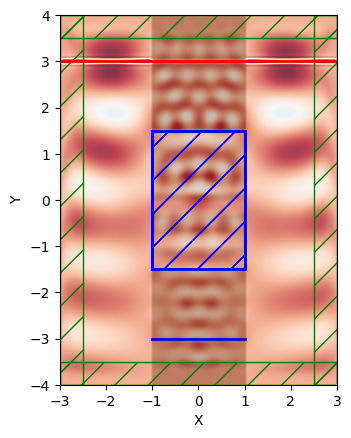

In [75]:
opt.prepare_forward_run()
src = mp.ContinuousSource(frequency=fcen, end_time = 25)
source = [
    mp.Source(src, component=mp.Ez, size=source_size, center=source_center,)
]
opt.sim.change_sources(source)
opt.plot2D()
plt.show()

opt.sim.run(mp.at_every(0.1, mp.output_png(mp.Ez, "-Zc dkbluered ")), until = 25)
opt.sim.plot2D(fields = mp.Ez)
plt.show()


In [79]:
'''
Make a GIF file from the output images and play in the notebook
'''
from IPython.display import Image, display
import imageio
import os

# Set the directory where the output images are saved
output_dir = "/root/"

# Get the list of image files in the directory
image_files = sorted([os.path.join(output_dir, file) for file in os.listdir(output_dir) if file.endswith(".png")])

# Create the GIF file
output_gif = "output.gif"
with imageio.get_writer(output_gif, mode="I") as writer:
    for image_file in image_files:
        image = imageio.imread(image_file)
        writer.append_data(image)

print("GIF file created: {}".format(output_gif))

gif_path = "output.gif"

# Display the GIF file
display(Image(filename=gif_path))


PermissionError: [Errno 13] Permission denied: '/root/'